In [366]:
#%reset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from num2words import num2words
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score

from sklearn.tree import DecisionTreeClassifier
oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=10) #need for neural network and random forest


In [3]:
all_state_weekly_data = pd.read_csv("all_state_weekly_data_cases_deaths_admissions_hospital.csv")
all_state_weekly_data = all_state_weekly_data.loc[:, all_state_weekly_data.columns != 'Unnamed: 0']
all_state_weekly_data = all_state_weekly_data.fillna(0)

In [4]:
column_names = ['state']
categories_for_subsetting = ['deaths', 'cases', 'hospitalizations', 'hospitalizations_delta_100k', 'admissions','admissions_delta_100k', 'over_15_100k']

for week in range(1, len(all_state_weekly_data) + 1):
    week = num2words(week)
    for category in categories_for_subsetting:
        column_name = f'week_{week}_{category}'
        column_names.append(column_name)


state_abb = []
for column in all_state_weekly_data.columns:
    state_abb.append(column[:2])
state_abb = set(state_abb[1:])


In [5]:
all_state_weekly_data_by_state = pd.DataFrame(index=range(51), columns=column_names)

x = 0

categories_for_subsetting = ['deaths', 'cases', 'hospitalizations', 'hospitalizations_delta_100k', 'admissions','admissions_delta_100k', 'over_15_100k']
for abb in state_abb:
    matching_indices = [i for i, state in enumerate(all_state_weekly_data) if state == abb]
    all_state_weekly_data_by_state.loc[x, 'state'] = abb
    columns_to_subset =  [f'{abb}_{category}' for category in categories_for_subsetting]
    j = 1
    for row in range(len(all_state_weekly_data.loc[:, columns_to_subset])):
        all_state_weekly_data_by_state.iloc[x, j:j + len(categories_for_subsetting)] = all_state_weekly_data.loc[row,columns_to_subset]
        j += 7
    x += 1

#all_state_weekly_data_by_state.set_index('state', inplace = True)

In [6]:
target_months= [col for col in all_state_weekly_data_by_state.columns if 'week_four_' in col]
X_train = all_state_weekly_data_by_state[target_months[0:len(target_months)-1]]
X_train.columns = range(1, len(X_train.columns) + 1)

y_train = all_state_weekly_data_by_state[target_months[-1]].astype(int)
X_train, y_train = oversample.fit_resample(X_train, y_train)


test_months= [col for col in all_state_weekly_data_by_state.columns if 'week_twenty_' in col]

X_test = all_state_weekly_data_by_state[test_months[0:len(test_months)-1]]
X_test.columns = range(1, len(X_test.columns) + 1)

y_test = all_state_weekly_data_by_state[test_months[-1]].astype(int)

In [7]:

# Create a decision tree classifier
clf = DecisionTreeClassifier()

# Train the decision tree classifier
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print(confusion_matrix(y_test, y_pred))


Accuracy: 0.9607843137254902
[[11  0]
 [ 2 38]]


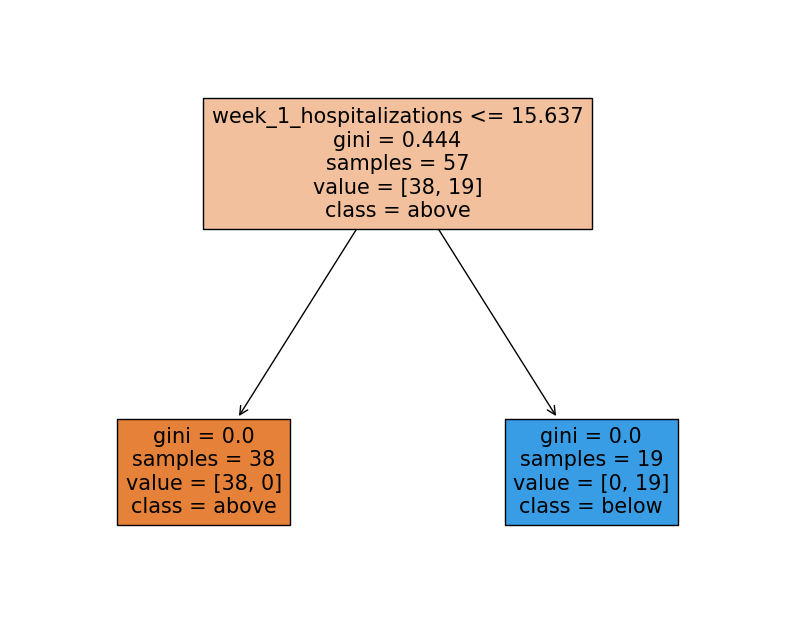

In [8]:
plt.figure(figsize=(10, 8))
plot_tree(clf, feature_names=['week_1_deaths',	'week_1_cases',	'week_1_hospitalizations',	'week_1_hospitalizations_delta_100k	week_1_admissions',	'week_1_admissions_delta_100k'], class_names=['above', 'below'], filled=True)
plt.show()

# Try counties 

In [286]:
data_by_county = pd.read_csv('/Users/rem76/Documents/COVID_projections/County_level_hospitalizations_death.csv')
data_by_county.columns
data_by_county['CTYNAME'] = data_by_county['CTYNAME'].apply(lambda x: x.split()[0])


Some counties have the same name as others - need to make them unique 

In [287]:
data_by_county['CTYNAME'] = data_by_county['fips'].astype(str) + '' + data_by_county['CTYNAME']
len(data_by_county['CTYNAME'].unique())


3209

Create target data 
For the moment, do > 15 admits per 100k

In [288]:
#data_by_county.fillna(0)
data_by_county['admits_over_15_100k'] = (data_by_county['admits_weekly'] > 15)*1

In [289]:
data_by_county_over_15_100k = data_by_county[['CTYNAME', 'week', 'admits_over_15_100k']]


In [290]:

data_by_county_cases = data_by_county[['CTYNAME', 'week', 'cases_weekly']]
data_by_county_cases = data_by_county_cases.pivot_table(index= 'week', columns='CTYNAME', values='cases_weekly')
data_by_county_deaths = data_by_county[['CTYNAME', 'week', 'deaths_weekly']]
data_by_county_deaths = data_by_county_deaths.pivot_table(index= 'week', columns='CTYNAME', values='deaths_weekly')
data_by_county_admissions = data_by_county[['CTYNAME', 'week', 'admits_weekly']]
data_by_county_admissions = data_by_county_admissions.pivot_table(index= 'week', columns='CTYNAME', values='admits_weekly')
data_by_county_icu = data_by_county[['CTYNAME', 'week', 'icu_weekly']]
data_by_county_icu = data_by_county_icu.pivot_table(index= 'week', columns='CTYNAME', values='icu_weekly')
data_by_county_over_15_100k = data_by_county[['CTYNAME', 'week', 'admits_over_15_100k']]
data_by_county_over_15_100k = data_by_county_over_15_100k.pivot_table(index= 'week', columns='CTYNAME', values='admits_over_15_100k')
data_by_county_over_15_100k = data_by_county_over_15_100k.add_suffix('_admits_over_15_100k')



data_data_cases_death_weekly = pd.merge(data_by_county_cases, data_by_county_deaths, on='week')
new_column_names = [col.replace('_x', '_cases') for col in data_data_cases_death_weekly.columns]
data_data_cases_death_weekly.rename(columns=dict(zip(data_data_cases_death_weekly.columns, new_column_names)), inplace=True)

new_column_names = [col.replace('_y', '_deaths') for col in data_data_cases_death_weekly.columns]
data_data_cases_death_weekly.rename(columns=dict(zip(data_data_cases_death_weekly.columns, new_column_names)), inplace=True)

data_data_admits_icu_weekly = pd.merge(data_by_county_admissions, data_by_county_icu, on='week')
new_column_names = [col.replace('_x', '_admit') for col in data_data_admits_icu_weekly.columns]
data_data_admits_icu_weekly.rename(columns=dict(zip(data_data_admits_icu_weekly.columns, new_column_names)), inplace=True)

new_column_names = [col.replace('_y', '_icu') for col in data_data_admits_icu_weekly.columns]
data_data_admits_icu_weekly.rename(columns=dict(zip(data_data_admits_icu_weekly.columns, new_column_names)), inplace=True)



data_by_county_cases_deaths_admits_icu = pd.merge(data_data_cases_death_weekly, data_data_admits_icu_weekly, on='week')
data_by_county_cases_deaths_admits_icu = pd.merge(data_by_county_cases_deaths_admits_icu, data_by_county_over_15_100k, on='week')
data_by_county_cases_deaths_admits_icu = data_by_county_cases_deaths_admits_icu.reset_index()



In [294]:
data_by_county_cases_deaths_admits_icu.columns = [col.split()[0] for col in data_by_county_cases_deaths_admits_icu.columns]


In [292]:
data_by_county_cases_deaths_admits_icu.to_csv("County_level_hospitalizations_death_by_county.csv")

In [297]:
column_names = ['county']
categories_for_subsetting = ['cases', 'deaths', 'admit', 'icu','admits_over_15_100k']

for week in range(1, len(data_by_county_cases_deaths_admits_icu) + 1):
    week = num2words(week)
    for category in categories_for_subsetting:
        column_name = f'week_{week}_{category}'
        column_names.append(column_name)



In [298]:
all_county_weekly_data = pd.DataFrame(index=range(51), columns=column_names)

x = 0

categories_for_subsetting = ['cases', 'deaths', 'admit', 'icu','admits_over_15_100k']
for county in data_by_county['CTYNAME'].unique():
    matching_indices = [i for i, county_col in enumerate(data_by_county_cases_deaths_admits_icu) if county_col == county]
    all_county_weekly_data.loc[x, 'county'] = county
    columns_to_subset =  tuple([f'{county}_{category}' for category in categories_for_subsetting]) 
    columns_to_subset =  [f'{county}_{category}' for category in categories_for_subsetting]

    j = 1
    try:
        for row in range(len(data_by_county_cases_deaths_admits_icu.loc[:, columns_to_subset])):
            all_county_weekly_data.iloc[x, j:j + len(categories_for_subsetting)] = data_by_county_cases_deaths_admits_icu.loc[row,columns_to_subset]
            j += 5
    except:
        pass
    x += 1


In [ ]:
### What i could do is, for each week, take something four weeks in advance and just create a larger dataset

In [355]:
def prep_training_test_data(data, proportion, no_weeks, weeks_in_futre, if_train):
## Get the weeks for the x and y datasets   
    x_weeks = []  
    y_weeks = []
    for week in no_weeks:
        test_week = int(week) + weeks_in_futre
        x_weeks.append('_' + num2words(week) + '_')
        y_weeks.append('_' + num2words(test_week) + '_')
    
## Divide up the test/train split
    #if is_geographic:
        # Calculate the index to start slicing from
    #    start_index = len(data['county']) // proportion[0] * proportion[1]
        # Divide up the dataset based on this proportion
    #    first_two_thirds = data['county'][:start_index]
    #    last_third = data['county'][start_index:]
    X_data = pd.DataFrame()
    y_data = pd.DataFrame()
    ## Now get the training data 
    X_sum = 0
    sum_counties = 0 
    for x_week in x_weeks:
            y_week = y_weeks[0]
            weeks_x = [col for col in data.columns if x_week in col]
            columns_x  = ['county'] + weeks_x
            data_x = data[columns_x]
   
            weeks_y = [col for col in data.columns if y_week in col]
            columns_y  = ['county'] + weeks_y
            data_y = data[columns_y]
            sum_counties = sum_counties + len(data['county'].unique())
            # ensure they have the same amount of data
            #remove rows in test_data1 with NA in test_data2
            data_x = data_x.dropna()
            data_x = data_x[data_x['county'].isin(data_y['county'])]
            # remove rows in test_data2 with NA in test_data1
            data_y = data_y.dropna()
            data_y = data_y[data_y['county'].isin(data_x['county'])]
            data_x = data_x[data_x['county'].isin(data_y['county'])]
            
            #rename columns for concatenation 
            data_x.columns = range(1, len(data_x.columns) + 1)
            data_y.columns = range(1, len(data_y.columns) + 1)
           
            X_week = data_x.iloc[:, 1:len(columns_x)-1]
            X_sum = X_sum + len(X_week)
            #print(X_week)
            y_week = data_y[len(columns_y)]
            #print(y_week)

            y_week = y_week.astype(int)
            if if_train:
                 X_week, y_week = oversample.fit_resample(X_week, y_week)

            X_data = pd.concat([X_data, X_week])
            y_data = pd.concat([y_data, y_week]) 

    X_data.reset_index(drop=True, inplace=True)
    y_data.reset_index(drop=True, inplace=True)
    return(X_data, y_data)




In [383]:
#X_train, y_train = prep_training_test_data(all_county_weekly_data, [3,2], no_weeks = range(1, int(24*2/3) + 1), weeks_in_futre = 4, if_train = True)
X_train, y_train = prep_training_test_data(all_county_weekly_data, [3,2], no_weeks = range(1, int(24*2/3) + 1), weeks_in_futre = 4, if_train = True)

X_test, y_test = prep_training_test_data(all_county_weekly_data, [3,2], range(int(24*2/3) + 1, 25), 4, if_train = False)

Percentage of missing data

In [359]:
print(((len(data_by_county['CTYNAME'].unique()) * 16) - len(X_train)) / (len(data_by_county['CTYNAME'].unique()) * 16) * 100) # 1.2036459956372703

print(((len(data_by_county['CTYNAME'].unique()) * 8) - len(X_test)) / (len(data_by_county['CTYNAME'].unique()) * 8) * 100) # 0.17918354627609848


1.2036459956372703
0.17918354627609848


In [115]:

target_week = ['_ten_', '_fourteen_']

target_months1= [col for col in all_county_weekly_data.columns if target_week[0] in col]
target_columns1 = ['county'] + target_months1
train_data1= all_county_weekly_data[target_columns1]
train_data1 = train_data1[train_data1['county'].isin(first_two_thirds)]

train_data1.columns = range(1, len(train_data1.columns) + 1)
target_months2= [col for col in all_county_weekly_data.columns if target_week[1] in col]
target_columns2 = ['county'] + target_months2
train_data2= all_county_weekly_data[target_columns2]
train_data2 = train_data2[train_data2['county'].isin(first_two_thirds)]

train_data2.columns = range(1, len(train_data2.columns) + 1)
# Remove rows in train_data1 with NA in train_data2
train_data1 = train_data1.dropna(subset=range(2, len(train_data1.columns) + 1))
train_data1 = train_data1.dropna()

# Remove rows in train_data2 with NA in train_data1
train_data2 = train_data2.dropna(subset=range(2, len(train_data2.columns) + 1))
train_data2 = train_data2.dropna()

X_train = train_data1.iloc[:, 1:len(target_months1)]
X_train.columns = range(1, len(X_train.columns) + 1)
y_train = train_data2.iloc[:, len(target_months1)]
y_train = y_train.astype(int)

X_train, y_train = oversample.fit_resample(X_train, y_train)

target_months1= [col for col in all_county_weekly_data.columns if target_week[0] in col]
target_columns1 = ['county'] + target_months1
test_data1= all_county_weekly_data[target_columns1]
test_data1 = test_data1[test_data1['county'].isin(last_third)]

target_months2= [col for col in all_county_weekly_data.columns if target_week[1] in col]
target_columns2 = ['county'] + target_months2
test_data2= all_county_weekly_data[target_columns2]
test_data2 = test_data2[test_data2['county'].isin(last_third)]

# Remove rows in test_data1 with NA in test_data2
test_data1 = test_data1.dropna()
test_data1 = test_data1[test_data1['county'].isin(test_data2['county'])]

# Remove rows in test_data2 with NA in test_data1
test_data2 = test_data2.dropna()
test_data2 = test_data2[test_data2['county'].isin(test_data1['county'])]
test_data1 = test_data1[test_data1['county'].isin(test_data2['county'])]

test_data1.columns = range(1, len(test_data1.columns) + 1)
test_data2.columns = range(1, len(test_data2.columns) + 1)

X_test = test_data1.iloc[:, 1:len(target_months1)]
X_test.columns = range(1, len(X_test.columns) + 1)
y_test = test_data2.iloc[:, len(target_months1)]
y_test = y_test.astype(int)

Accuracy: 0.6603839850152189
auROC: 0.6603839850152189
[[ 4007  1121]
 [ 7582 12916]]


[Text(0.5180435037523452, 0.95, 'admit <= 11.9\ngini = 0.444\nsamples = 59273\nvalue = [39516, 19757]\nclass = above'),
 Text(0.25032246716697937, 0.85, 'deaths <= 1.481\ngini = 0.305\nsamples = 39174\nvalue = [31826, 7348]\nclass = above'),
 Text(0.1227720450281426, 0.75, 'admit <= 7.26\ngini = 0.199\nsamples = 24972\nvalue = [22177, 2795]\nclass = above'),
 Text(0.06414165103189494, 0.65, 'cases <= 84.5\ngini = 0.162\nsamples = 20927\nvalue = [19071, 1856]\nclass = above'),
 Text(0.026969981238273922, 0.55, 'admit <= 0.245\ngini = 0.134\nsamples = 15817\nvalue = [14677, 1140]\nclass = above'),
 Text(0.012195121951219513, 0.45, 'admit <= 0.231\ngini = 0.179\nsamples = 5286\nvalue = [4761, 525]\nclass = above'),
 Text(0.010318949343339587, 0.35, 'cases <= 39.5\ngini = 0.177\nsamples = 5279\nvalue = [4761, 518]\nclass = above'),
 Text(0.005628517823639775, 0.25, 'admit <= 0.096\ngini = 0.141\nsamples = 3549\nvalue = [3278, 271]\nclass = above'),
 Text(0.00375234521575985, 0.15, 'cases <

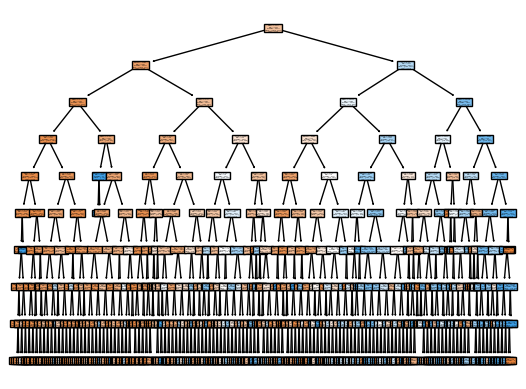

In [384]:
# Create a decision tree classifier
param_grid = {
    'criterion': ['gini'],#, 'entropy'],
    'max_depth': np.arange(1, 10),
    'min_samples_split': np.arange(50, 200),
    'min_samples_leaf': np.arange(50, 200)
}

param_grid = {
    'criterion': ['gini'],#, 'entropy'],
    'max_depth': np.arange(1, 10),
    'min_samples_split':  np.arange(2, 100), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(2, 100) #100, 200, 300, 400, 500], #np.arange(500, 200)
}

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

clf = DecisionTreeClassifier(random_state=10)

# Perform Randomized Search with 10-fold cross-validation
random_search = RandomizedSearchCV(clf, param_grid, n_iter=100, cv=cv, random_state=10)
random_search.fit(X_train, y_train)

best_params = random_search.best_params_

# Create the Decision Tree classifier with the best hyperparameters
clf = DecisionTreeClassifier(**best_params, random_state=10)

# Train the decision tree classifier
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
ROC = roc_auc_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("auROC:", accuracy)

print(confusion_matrix(y_test, y_pred))
plot_tree(clf, feature_names=['cases', 'deaths', 'admit', 'icu'	], class_names=['above', 'below'], filled=True)


Number of nodes in the last tree is: 1 with ccp_alpha: 0.08280619266994682


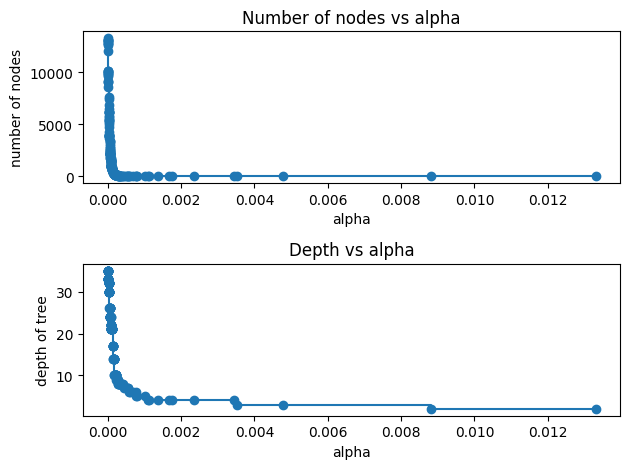

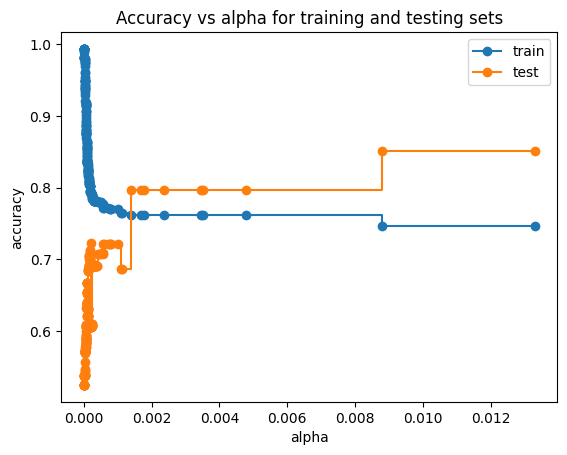

Best Hyperparameters:  {'min_samples_split': 64, 'min_samples_leaf': 32, 'max_depth': 4, 'criterion': 'gini', 'ccp_alpha': 0.005}
Best Score:  0.7526075056917187
Accuracy: 0.8514009209396707
[[ 3252  1876]
 [ 1932 18566]]


[Text(0.5, 0.8333333333333334, 'admit <= 11.9\ngini = 0.444\nsamples = 59273\nvalue = [39516, 19757]\nclass = above'),
 Text(0.25, 0.5, 'deaths <= 1.481\ngini = 0.305\nsamples = 39174\nvalue = [31826, 7348]\nclass = above'),
 Text(0.125, 0.16666666666666666, 'gini = 0.199\nsamples = 24972\nvalue = [22177, 2795]\nclass = above'),
 Text(0.375, 0.16666666666666666, 'gini = 0.436\nsamples = 14202\nvalue = [9649, 4553]\nclass = above'),
 Text(0.75, 0.5, 'icu <= 5.777\ngini = 0.472\nsamples = 20099\nvalue = [7690, 12409]\nclass = below'),
 Text(0.625, 0.16666666666666666, 'gini = 0.498\nsamples = 12446\nvalue = [5874, 6572]\nclass = below'),
 Text(0.875, 0.16666666666666666, 'gini = 0.362\nsamples = 7653\nvalue = [1816, 5837]\nclass = below')]

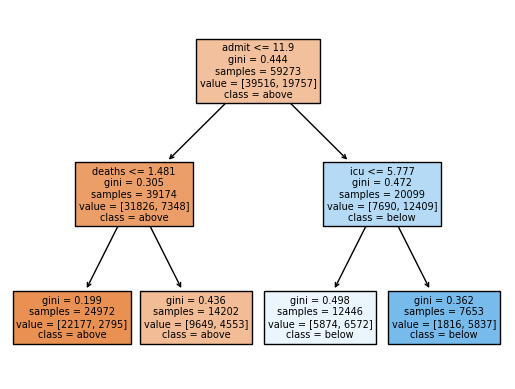

In [397]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

# Find the optimal alpha value
#optimal_alpha = ccp_alphas[np.argmax(impurities)]

# Prune the Decision Tree using the optimal alpha value
param_grid = {
    'criterion': ['gini'],#, 'entropy'],
    'max_depth': np.arange(1, 10),
    'min_samples_split':  np.arange(2, 100), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(2, 200), #100, 200, 300, 400, 500], #np.arange(500, 200)
    'ccp_alpha': np.arange(0.005, 0.013, 0.001) }


# Create the Decision Tree classifier
#cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=20,random_state=1) ## 10-fold cross validations

#X_train, y_train = oversample.fit_resample(X_train, y_train)

# Perform Randomized Search with 10-fold cross-validation
random_search = RandomizedSearchCV(clf, param_grid, n_iter=100, cv=cv, random_state=10)
random_search.fit(X_train, y_train)
print("Best Hyperparameters: ", random_search.best_params_)
print("Best Score: ", random_search.best_score_)

best_params = random_search.best_params_

# Create the Decision Tree classifier with the best hyperparameters
clf = DecisionTreeClassifier(**best_params, random_state=10) #, ccp_alpha=0.00385301)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print(confusion_matrix(y_test, y_pred))
plot_tree(clf, feature_names=['cases', 'deaths', 'admit', 'icu'	], class_names=['above', 'below'], filled=True)




In [396]:
random_search.best_params_

{'min_samples_split': 3,
 'min_samples_leaf': 96,
 'max_depth': 9,
 'criterion': 'gini',
 'ccp_alpha': 0.008}

Accuracy: 0.8514009209396707
[[ 3252  1876]
 [ 1932 18566]]


[Text(0.6, 0.8333333333333334, 'admit <= 11.9\ngini = 0.444\nsamples = 59273\nvalue = [39516, 19757]\nclass = above'),
 Text(0.4, 0.5, 'deaths <= 1.481\ngini = 0.305\nsamples = 39174\nvalue = [31826, 7348]\nclass = above'),
 Text(0.2, 0.16666666666666666, 'gini = 0.199\nsamples = 24972\nvalue = [22177, 2795]\nclass = above'),
 Text(0.6, 0.16666666666666666, 'gini = 0.436\nsamples = 14202\nvalue = [9649, 4553]\nclass = above'),
 Text(0.8, 0.5, 'gini = 0.472\nsamples = 20099\nvalue = [7690, 12409]\nclass = below')]

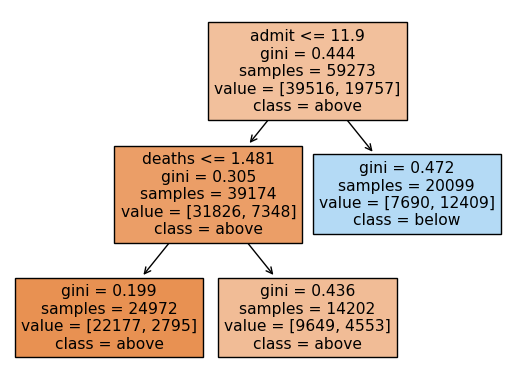

In [389]:
#best_params = random_search.best_params_

# Create the Decision Tree classifier with the best hyperparameters
clf = DecisionTreeClassifier(**best_params, random_state=10) #, ccp_alpha=0.00385301)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print(confusion_matrix(y_test, y_pred))
plot_tree(clf, feature_names=['cases', 'deaths', 'admit', 'icu'	], class_names=['above', 'below'], filled=True)


In [398]:
n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
threshold = clf.tree_.threshold

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print(
    "The binary tree structure has {n} nodes and has "
    "the following tree structure:\n".format(n=n_nodes)
)
for i in range(n_nodes):
    if is_leaves[i]:
        print(
            "{space}node={node} is a leaf node.".format(
                space=node_depth[i] * "\t", node=i
            )
        )
    else:
        print(
            "{space}node={node} is a split node: "
            "go to node {left} if X[:, {feature}] <= {threshold} "
            "else to node {right}.".format(
                space=node_depth[i] * "\t",
                node=i,
                left=children_left[i],
                feature=feature[i],
                threshold=threshold[i],
                right=children_right[i],
            )
        )

The binary tree structure has 7 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if X[:, 2] <= 11.899549007415771 else to node 4.
	node=1 is a split node: go to node 2 if X[:, 1] <= 1.481471061706543 else to node 3.
		node=2 is a leaf node.
		node=3 is a leaf node.
	node=4 is a split node: go to node 5 if X[:, 3] <= 5.7767393589019775 else to node 6.
		node=5 is a leaf node.
		node=6 is a leaf node.
